# Librerias

In [1]:
import os
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Crear Sesión Spark

In [2]:
spark = (
    SparkSession
        .builder
        .master("local")
        .appName("bike-prediction")
        .getOrCreate()
)

In [3]:
current_path =  os.getcwd()
train_file_path =  './data_bike/train.csv'
test_file_path = './data_bike/test.csv'
historical_file_path = './data_bike/historical.csv'
train_path = os.path.join(current_path, train_file_path)
test_path = os.path.join(current_path, test_file_path)
historical_path = os.path.join(current_path, historical_file_path)

In [4]:
train_df = (
    spark.read
    .option('header', 'true')
    .format('csv')
    .load(train_path)
)
test_df = (
    spark.read
    .option('header', 'true')
    .format('csv')
    .load(test_path)
)
historical_df = (
    spark.read
    .option('header', 'true')
    .format('csv')
    .load(historical_path)
)

In [5]:
train_df.limit(5).toPandas()

date_observacional holiday workingday weathersit
0         2011-01-15       0          1          1
1         2011-01-16       0          1          1
2         2011-01-17       0          1          1
3         2011-01-18       0          1          1
4         2011-01-19       0          1          1

In [6]:
test_df.limit(5).toPandas()

date_observacional holiday workingday weathersit
0         2012-11-01       0          0          2
1         2012-11-02       0          0          2
2         2012-11-03       0          1          1
3         2012-11-04       0          1          1
4         2012-11-05       0          1          1

In [7]:
historical_df.limit(5).toPandas()

dteday      temp     atemp       hum windspeed rents
0  2011-01-01  0.344167  0.363625  0.805833  0.160446   331
1  2011-01-02  0.363478  0.353739  0.696087  0.248539   131
2  2011-01-03  0.196364  0.189405  0.437273  0.248309   120
3  2011-01-04       0.2  0.212122  0.590435  0.160296   108
4  2011-01-05  0.226957   0.22927  0.436957    0.1869    82

In [8]:
# Missing Values

In [9]:
from pyspark.sql.functions import col, sum
missing_counts = historical_df.select([sum(col(columna).isNull().cast("int")).alias(columna) for columna in historical_df.columns])
missing_counts.show()

+------+----+-----+---+---------+-----+
|dteday|temp|atemp|hum|windspeed|rents|
+------+----+-----+---+---------+-----+
|     0|  35|   35| 34|       33|    0|
+------+----+-----+---+---------+-----+



In [10]:
historical_df_pandas = historical_df.toPandas()

In [11]:
historical_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dteday     731 non-null    object
 1   temp       696 non-null    object
 2   atemp      696 non-null    object
 3   hum        697 non-null    object
 4   windspeed  698 non-null    object
 5   rents      731 non-null    object
dtypes: object(6)
memory usage: 34.4+ KB


In [12]:
# convertir a numericos:
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'rents']
for col in numeric_columns:
    historical_df_pandas[col] = pd.to_numeric(historical_df_pandas[col], errors='coerce')
historical_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dteday     731 non-null    object 
 1   temp       696 non-null    float64
 2   atemp      696 non-null    float64
 3   hum        697 non-null    float64
 4   windspeed  698 non-null    float64
 5   rents      731 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 34.4+ KB


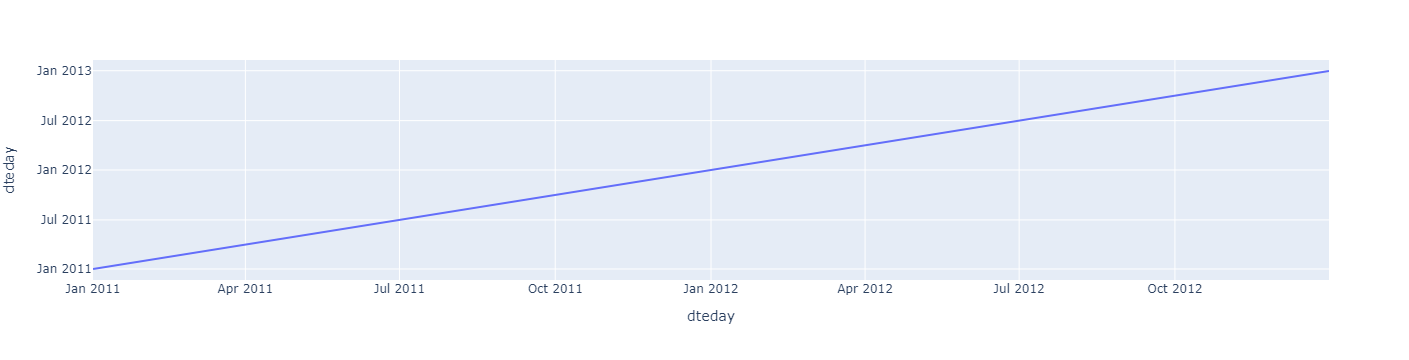

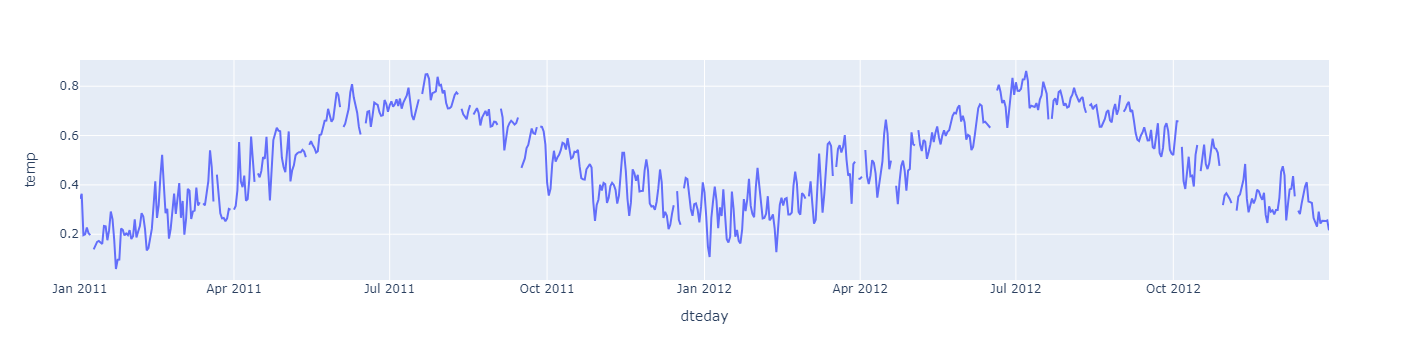

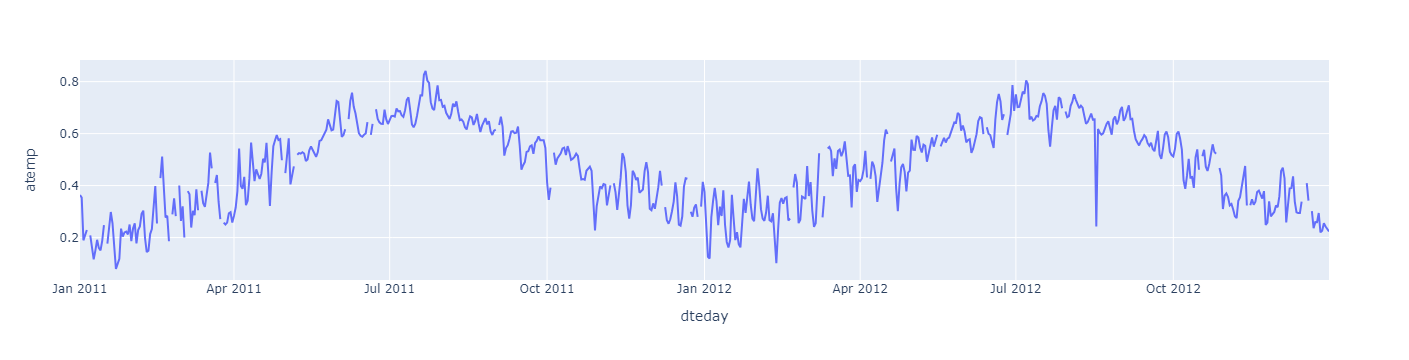

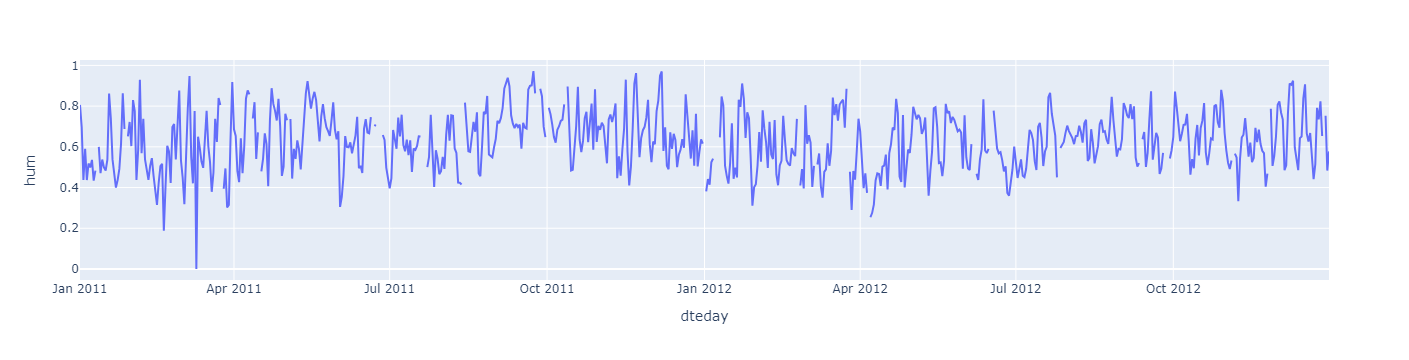

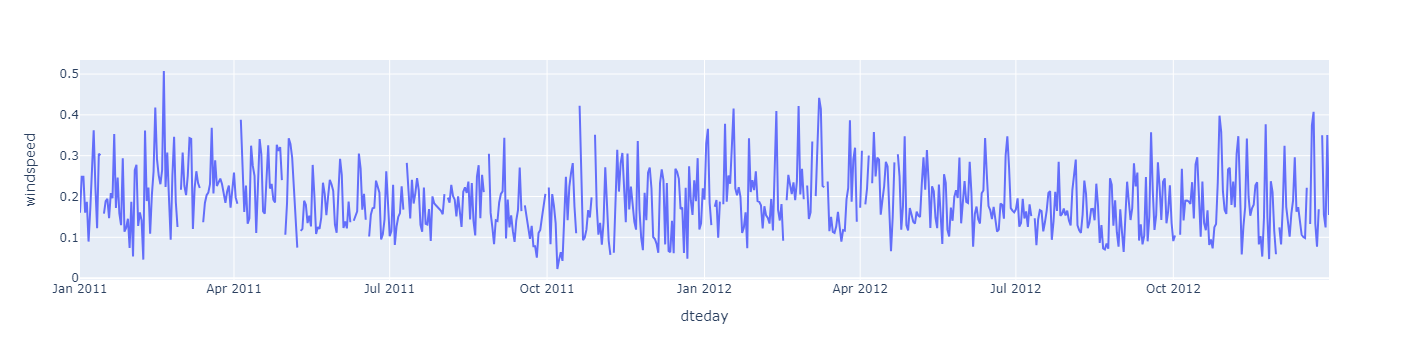

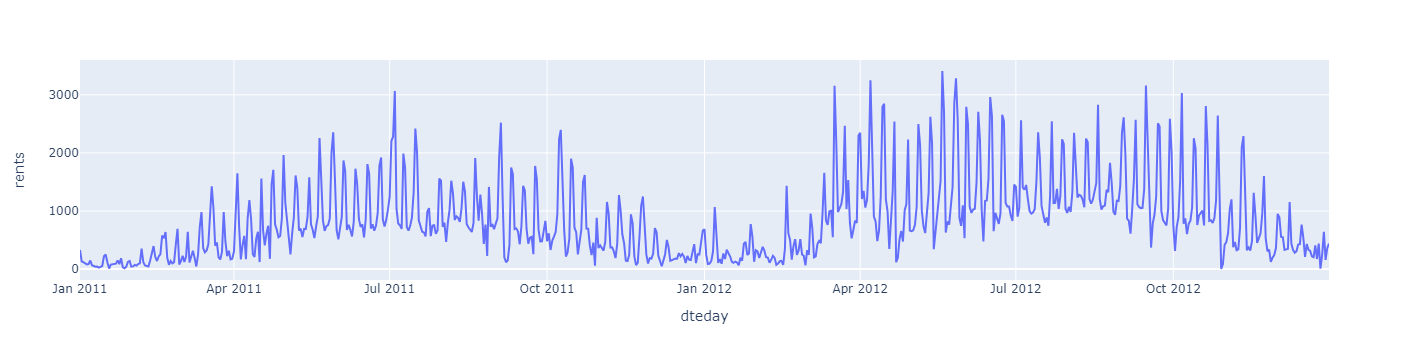

In [13]:
import plotly.express as px
import pandas as pd

for column in historical_df_pandas.columns:
    #fig = px.line(x=historical_df_pandas['dteday'], y=historical_df_pandas[column])
    fig = px.line(historical_df_pandas, x='dteday', y=column)
    fig.show()

# Missing values

## generando missing values 

In [14]:
rents_missing = historical_df_pandas.copy()
np.random.seed(0)
porcentaje_a_eliminar = 0.1 
mask_eliminar = np.random.rand(len(rents_missing)) < porcentaje_a_eliminar
rents_missing.loc[mask_eliminar, 'rents'] = np.nan

In [15]:
rents_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dteday     731 non-null    object 
 1   temp       696 non-null    float64
 2   atemp      696 non-null    float64
 3   hum        697 non-null    float64
 4   windspeed  698 non-null    float64
 5   rents      653 non-null    float64
dtypes: float64(5), object(1)
memory usage: 34.4+ KB


In [16]:
historical_df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dteday     731 non-null    object 
 1   temp       696 non-null    float64
 2   atemp      696 non-null    float64
 3   hum        697 non-null    float64
 4   windspeed  698 non-null    float64
 5   rents      731 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 34.4+ KB


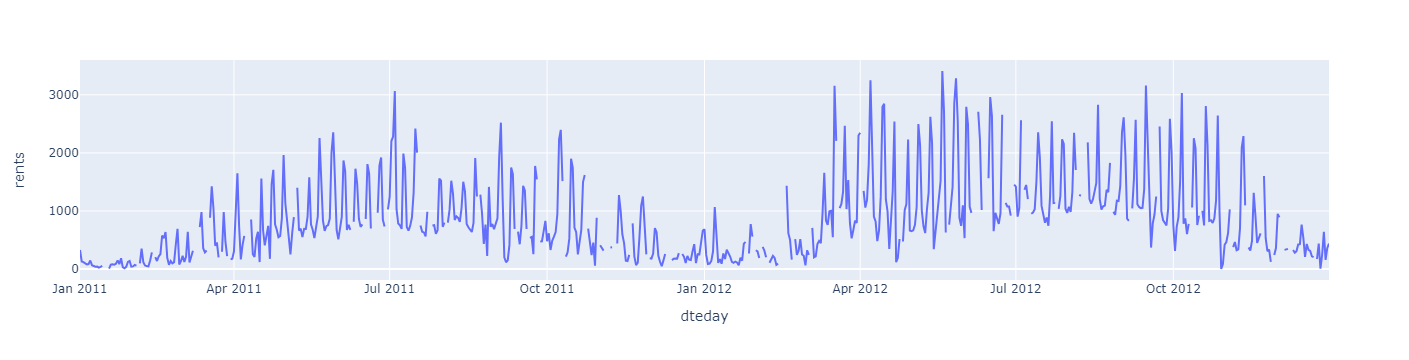

In [17]:
fig = px.line(rents_missing, x='dteday', y='rents')
fig.show()

# Improving model

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class ImputeWithMovingAverage(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute, window_size):
        self.columns_to_impute = columns_to_impute
        self.window_size = window_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns_to_impute:
            for i in range(len(X)):
                if pd.isnull(X_copy.at[i, col]):
                    start_idx = max(0, i - self.window_size)
                    end_idx = i
                    window_data = X_copy.loc[start_idx:end_idx, col]
                    mean = window_data.mean()
                    X_copy.at[i, col] = mean
        return X_copy

In [19]:
imputer_mean_prev_day = rents_missing.copy()
columns_to_impute = ['rents']
window_size = 3
imputer = ImputeWithMovingAverage(columns_to_impute, window_size)
imputer_mean_prev_day = imputer.transform(imputer_mean_prev_day)
imputer_mean_prev_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dteday     731 non-null    object 
 1   temp       696 non-null    float64
 2   atemp      696 non-null    float64
 3   hum        697 non-null    float64
 4   windspeed  698 non-null    float64
 5   rents      731 non-null    float64
dtypes: float64(5), object(1)
memory usage: 34.4+ KB


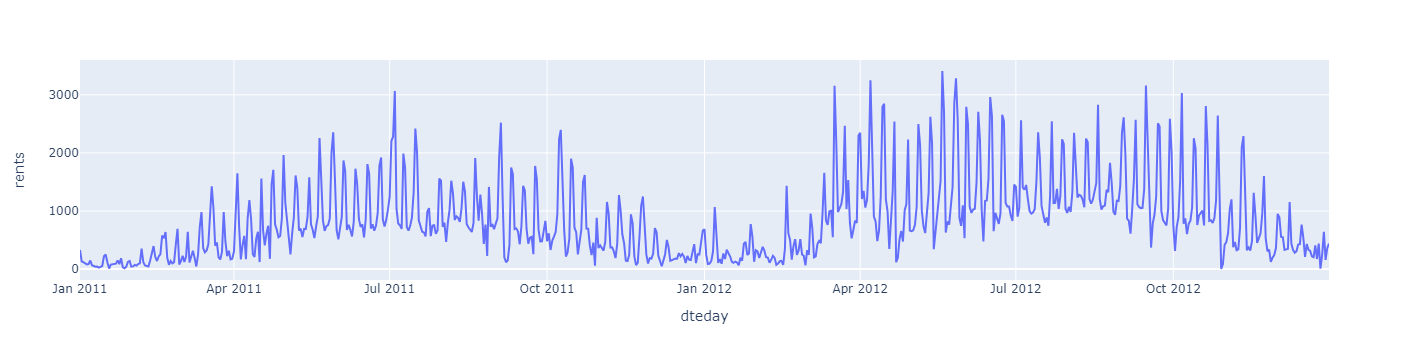

In [20]:
fig = px.line(historical_df_pandas, x='dteday', y='rents')
fig.show()

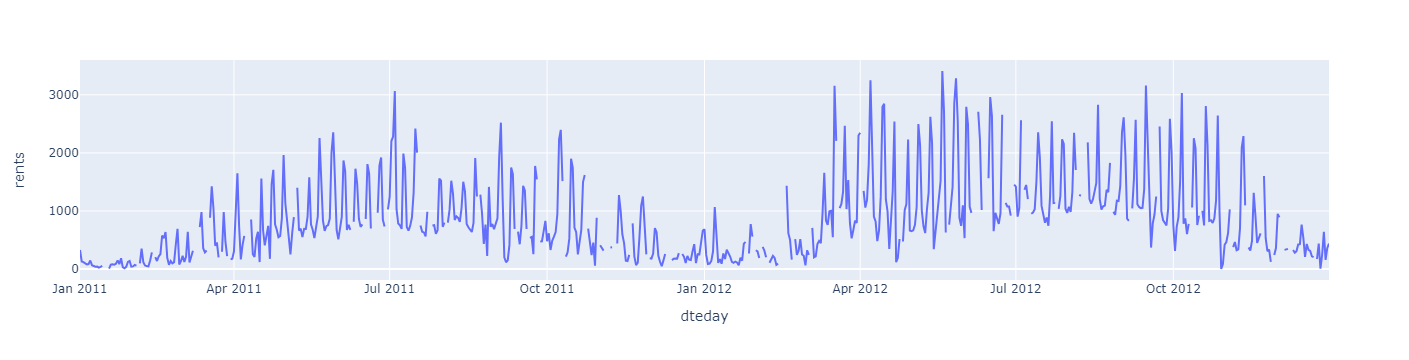

In [21]:
fig = px.line(rents_missing, x='dteday', y='rents')
fig.show()

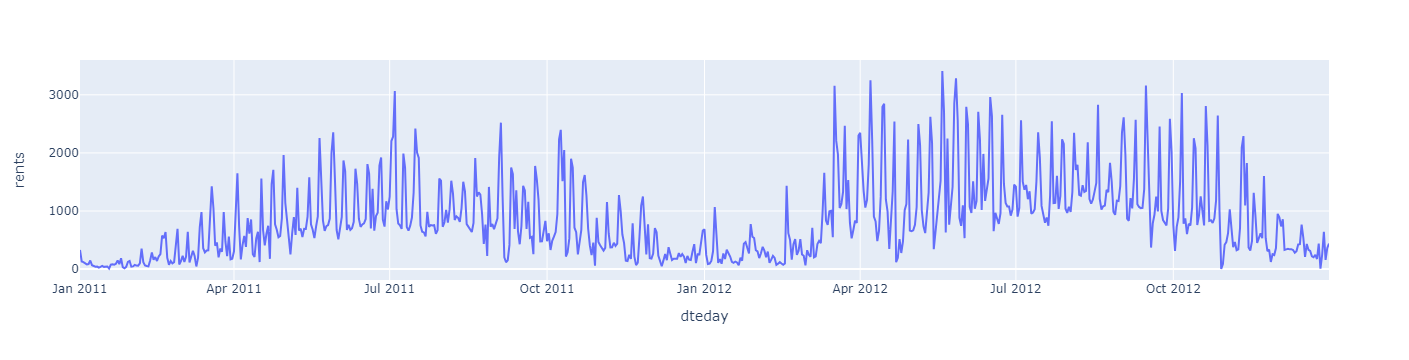

In [22]:
fig = px.line(imputer_mean_prev_day, x='dteday', y='rents')
fig.show()

##  InterpolateWithModePrevDay

In [23]:
class ImputeWithMovingMode(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute, window_size):
        self.columns_to_impute = columns_to_impute
        self.window_size = window_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns_to_impute:
            for i in range(len(X)):
                if pd.isnull(X_copy.at[i, col]):
                    start_idx = max(0, i - self.window_size)
                    end_idx = i
                    window_data = X_copy.loc[start_idx:end_idx, col]
                    mode = window_data.mode().iloc[0] 
                    X_copy.at[i, col] = mode
        return X_copy

In [24]:
rents_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dteday     731 non-null    object 
 1   temp       696 non-null    float64
 2   atemp      696 non-null    float64
 3   hum        697 non-null    float64
 4   windspeed  698 non-null    float64
 5   rents      653 non-null    float64
dtypes: float64(5), object(1)
memory usage: 34.4+ KB


In [25]:
imputer_mode_prev_day = rents_missing.copy()
columns_to_impute = ['rents']
window_size = 3
imputer = ImputeWithMovingMode(columns_to_impute, window_size)
imputer_mode_prev_day = imputer.transform(imputer_mode_prev_day)
imputer_mode_prev_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dteday     731 non-null    object 
 1   temp       696 non-null    float64
 2   atemp      696 non-null    float64
 3   hum        697 non-null    float64
 4   windspeed  698 non-null    float64
 5   rents      731 non-null    float64
dtypes: float64(5), object(1)
memory usage: 34.4+ KB


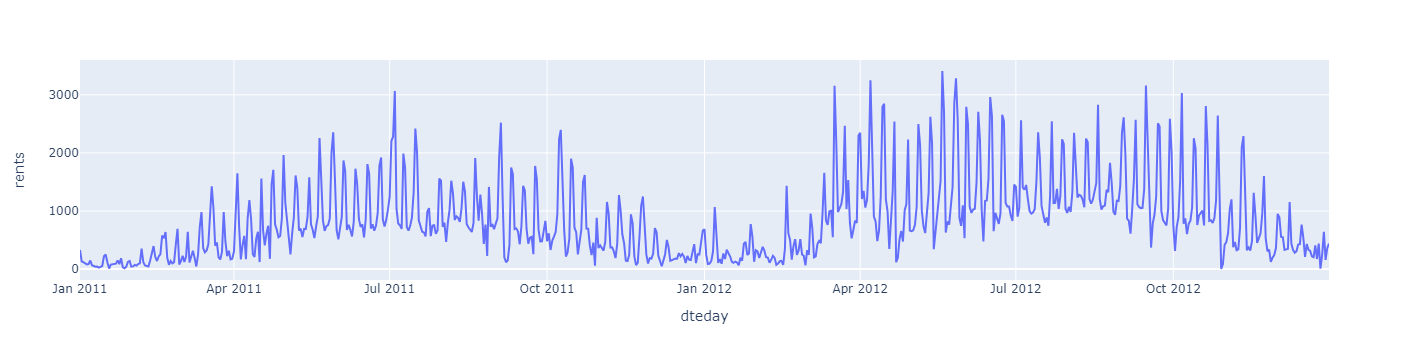

In [26]:
fig = px.line(historical_df_pandas, x='dteday', y='rents')
fig.show()

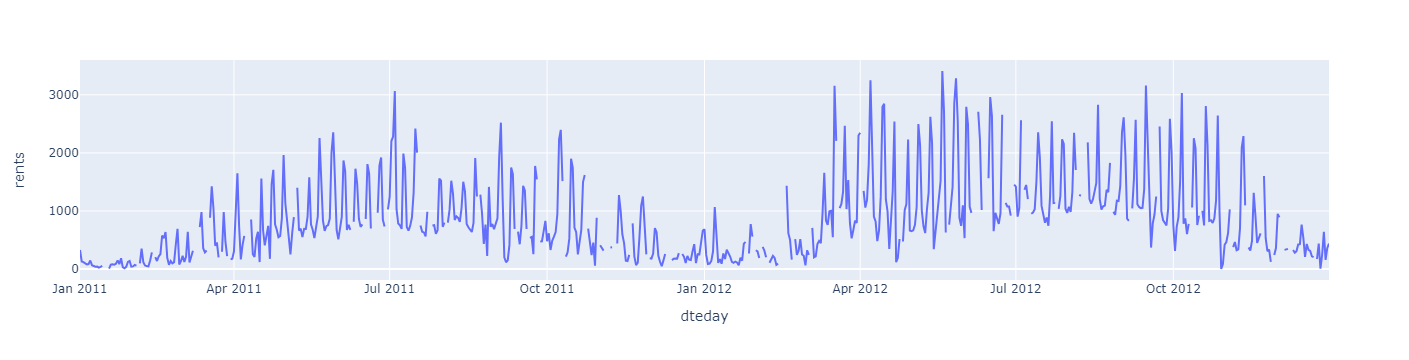

In [27]:
fig = px.line(rents_missing, x='dteday', y='rents')
fig.show()

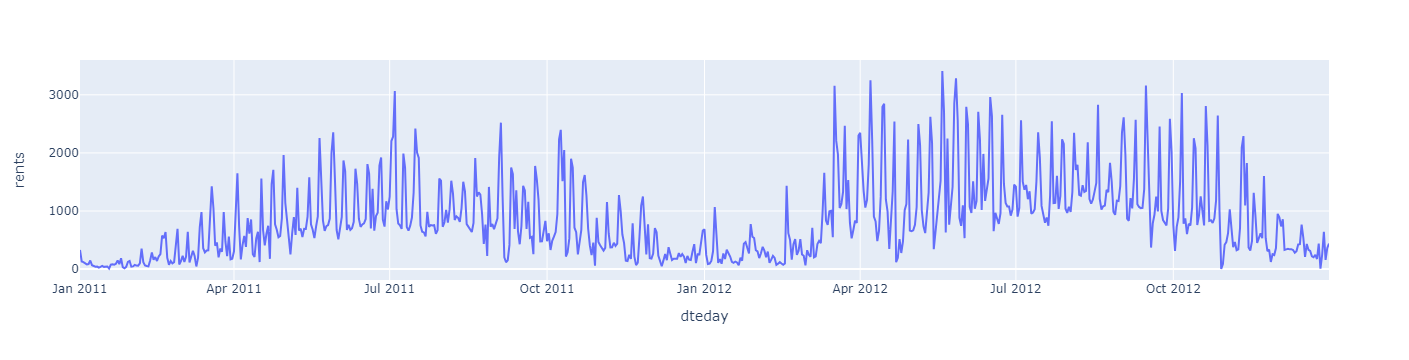

In [28]:
fig = px.line(imputer_mean_prev_day, x='dteday', y='rents')
fig.show()

##  Input with the mean of last n dayOfWeek

In [31]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class InputerMeanOfLastNDayOfWeek(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute, window_size):
        self.columns_to_impute = columns_to_impute
        self.window_size = window_size

    def fit(self, X, y=None):
        self.imputation_values = {}
        for column in self.columns_to_impute:
            self.imputation_values[column] = X[column].mean()  # Valor predeterminado si no hay datos para imputar
        self.X_with_dow = X.copy()
        self.X_with_dow['dteday'] = pd.to_datetime(self.X_with_dow['dteday'])
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns_to_impute:
            X_copy[column] = X_copy.apply(lambda row: self.impute_by_dow(row, column), axis=1)
        return X_copy

    def impute_by_dow(self, row, column):
        nan_value = row[column]
        if pd.isna(nan_value):
            current_date = row['dteday']
            dow = current_date.dayofweek  # Obtener el día de la semana (0=Lunes, 1=Martes, ..., 6=Domingo)
            start_date = current_date - pd.DateOffset(days=self.window_size * 7)  # Retroceder en el tiempo
            relevant_data = self.X_with_dow[(self.X_with_dow['dteday'] >= start_date) & (self.X_with_dow['dteday'] < current_date)]
            relevant_values = relevant_data[relevant_data['dteday'].dt.dayofweek == dow][column]
            if not relevant_values.empty:
                imputed_value = relevant_values.mean()
                return imputed_value
            else:
                return self.imputation_values[column]  # Si no hay datos relevantes, usar el valor predeterminado
        else:
            return nan_value

# Ejemplo de uso:
# Supongamos que tienes un DataFrame df con las columnas 'dteday' y 'rents'
# y deseas imputar los valores NaN en 'rents' utilizando la estrategia de la media
# de los últimos n lunes si la fecha es un lunes, y así sucesivamente.
#imputer = CustomImputer(columns_to_impute=['rents'], window_size=5)
#imputer.fit(df)
#df_imputed = imputer.transform(df)

In [32]:
rents_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dteday     731 non-null    object 
 1   temp       696 non-null    float64
 2   atemp      696 non-null    float64
 3   hum        697 non-null    float64
 4   windspeed  698 non-null    float64
 5   rents      653 non-null    float64
dtypes: float64(5), object(1)
memory usage: 34.4+ KB


In [35]:
imputer_mode_prev_day = rents_missing.copy()
imputer_mode_prev_day['dteday'] = pd.to_datetime(imputer_mode_prev_day['dteday'])
columns_to_impute = ['rents']
window_size = 5
imputer = InputerMeanOfLastNDayOfWeek(columns_to_impute=['rents'], window_size=5)
imputer.fit(imputer_mode_prev_day)
imputer_mode_prev_day = imputer.transform(imputer_mode_prev_day)
imputer_mode_prev_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dteday     731 non-null    datetime64[ns]
 1   temp       696 non-null    float64       
 2   atemp      696 non-null    float64       
 3   hum        697 non-null    float64       
 4   windspeed  698 non-null    float64       
 5   rents      731 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 34.4 KB


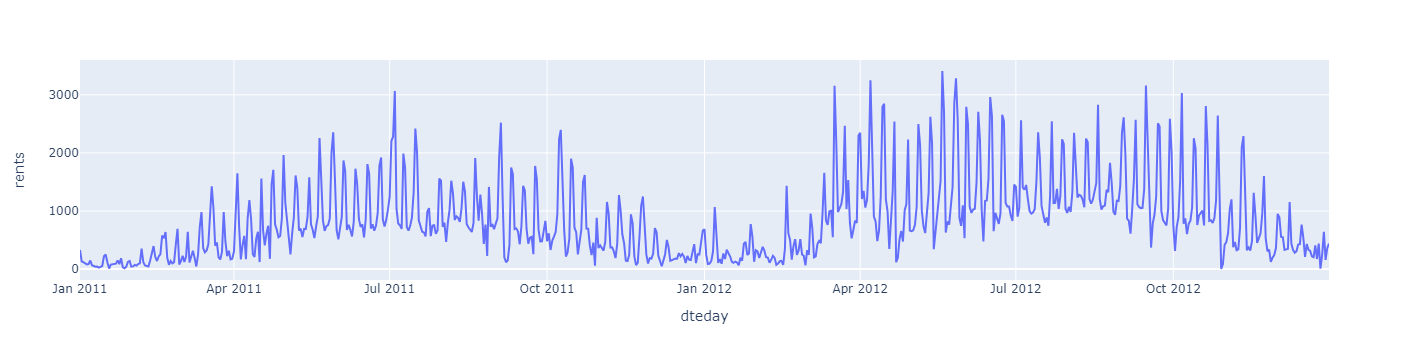

In [36]:
fig = px.line(historical_df_pandas, x='dteday', y='rents')
fig.show()

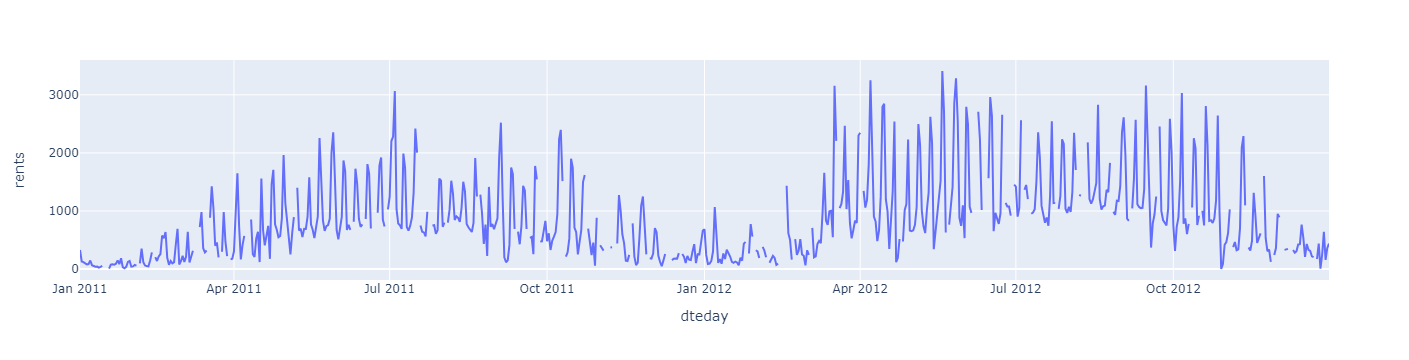

In [37]:
fig = px.line(rents_missing, x='dteday', y='rents')
fig.show()

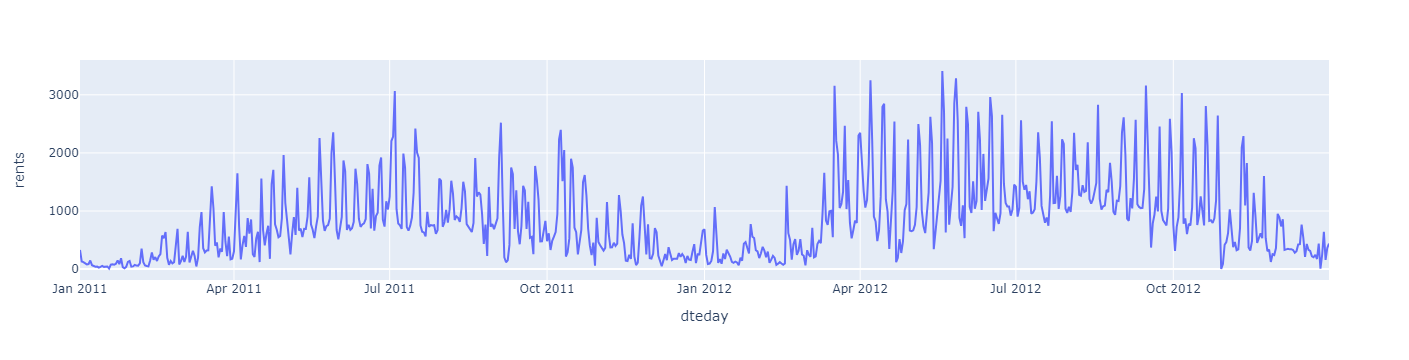

In [38]:
fig = px.line(imputer_mean_prev_day, x='dteday', y='rents')
fig.show()

## Spline Inputer

In [ ]:
# Hacerlo inputador

class SplineInterpolation(BaseEstimator, TransformerMixin):
    def __init__(self, date_column, value_column):
        self.date_column = date_column
        self.value_column = value_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.value_column] = X_copy.groupby(X_copy[self.date_column].dt.month)[self.value_column].transform(lambda x: x.interpolate(method='spline', order=3))
        return X_copy

## NearestInterpolation

In [ ]:
# Hacerlo inputador

class NearestInterpolation(BaseEstimator, TransformerMixin):
    def __init__(self, date_column, value_column):
        self.date_column = date_column
        self.value_column = value_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.value_column] = X_copy.groupby(X_copy[self.date_column].dt.month)[self.value_column].transform(lambda x: x.interpolate(method='nearest'))
        return X_copy

# Target 
**y = 'número total de bicicletas rentadas en los próx 30 dias'**

In [8]:
from pyspark.sql.types import *

def create_dataframe_from_schema(schema):
    empty_RDD = spark.sparkContext.emptyRDD()
    return spark.createDataFrame(empty_RDD, schema)

schema = StructType(
    [
        StructField("date_observacional", DateType(), True)
    ]
)

# Data generation

In [9]:
from pyspark.sql import DataFrame

class PrepareDatasets:
    
    def __init__(self, historical_df: DataFrame,
        x_key: str, historical_key: str):
        self.historical_df = historical_df
        self.x_key = x_key
        self.historical_key = historical_key
        self.keys = [F.col(f'x_df.{self.x_key}')
              ==F.col(f'historical_df.{self.historical_key}')]
    def _prepare_simple_join(self, x_df: DataFrame, consider_columns: list):
        

        filt_historical_df = (self.historical_df
                                  .select(consider_columns+[self.historical_key])
                             )
        x_new_df = x_df.alias('x_df').join(filt_historical_df
                                     .alias('historical_df'),
                    on=self.keys, how='left')
        
        return x_new_df.drop(self.historical_key)
    
    def _prepare_agg(self, x_df,
                consider_columns: list, dias_comp: list ):
        
        emp_df = create_dataframe_from_schema(schema)
        
        keys = [F.col(f'x_df.{self.x_key}')
              >=F.col(f'historical_df.{self.historical_key}')]
        
        full_df = (x_df.alias('x_df')
                  .join(self.historical_df
                        .alias('historical_df'), 
                on=keys, how='left')
                  .withColumn('diff_days', F.datediff(self.x_key, self.historical_key) )
              )
        
        for days_i in dias_comp:
            for column_i in consider_columns:
                
                filter_df = (full_df.filter(F.col('diff_days')<=days_i)
                                    .groupby(self.x_key)
                                    .agg(
                                       (
                                            F.mean(
                                                F.col(column_i)
                                            )
                                        ).alias(f"mean_{column_i}_last_" + str(days_i) + "_days")
                                        ,
                                        (
                                            F.max(
                                                F.col(column_i)
                                            )
                                        ).alias(f"max_{column_i}_last_" + str(days_i) + "_days")
                                        ,
                                        (
                                            F.stddev(
                                                F.col(column_i)
                                            )
                                        ).alias(f"stddev_{column_i}_last_" + str(days_i) + "_days")
                                        ,
                                        (
                                            F.variance(
                                                 F.col(column_i)
                                             ).alias(f"var_{column_i}_last_" + str(days_i) + "_days")
                                         ),
                                        (
                                            F.min(
                                                F.col(column_i)
                                            )
                                        ).alias(f"min_{column_i}_last_" + str(days_i) + "_days")

                                    )
                            )
                emp_df = emp_df.join(filter_df, on=self.x_key, how='full')
                
        return emp_df
    
    def run_all(self, x_df,
            consider_columns: list, dias_comp: list ):
        
        x_og = x_df.select(self.x_key)
        x_agg_1 = self._prepare_simple_join(x_df, consider_columns)
        x_agg_2 = self._prepare_agg(x_df, consider_columns, dias_comp)
        
        x_new = (x_og
                 .join(x_agg_1, on=[self.x_key], how='left')
                 .join(x_agg_2, on=[self.x_key], how='left')
                )
        return x_new

In [10]:
prepare_dataset = PrepareDatasets(
    historical_df=historical_df, 
    x_key='date_observacional', historical_key='dteday'
)
col_consider = ['temp', 'atemp', 'hum', 'windspeed', 'rents']
dias_consider = [3, 7, 15]

In [11]:
X_train_pro = prepare_dataset.run_all(train_df, col_consider, dias_consider)
X_test_pro = prepare_dataset.run_all(test_df, col_consider, dias_consider)

In [14]:
X_train_pro.limit(5).toPandas()

date_observacional holiday workingday weathersit      temp     atemp  \
0         2011-01-15       0          1          1  0.233333  0.248112   
1         2011-01-16       0          1          1  0.231667      None   
2         2011-01-17       0          1          1  0.175833  0.176771   
3         2011-01-18       0          1          1  0.216667  0.232333   
4         2011-01-19       0          1          1  0.292174  0.298422   

        hum windspeed rents  mean_temp_last_3_days  ...  \
0   0.49875  0.157963   222               0.182982  ...   
1   0.48375  0.188433   251               0.197717  ...   
2    0.5375  0.194017   117               0.200426  ...   
3  0.861667  0.146775     9               0.214375  ...   
4  0.741739  0.208317    78               0.229085  ...   

  mean_windspeed_last_15_days  max_windspeed_last_15_days  \
0                    0.214323                     0.36195   
1                    0.212597                     0.36195   
2                    0.214835                     0.36195   
3                    0.208051                     0.36195   
4                    0.205385                     0.36195   

   stddev_windspeed_last_15_days var_windspeed_last_15_days  \
0                       0.077715                   0.006040   
1                       0.075185                   0.005653   
2                       0.074013                   0.005478   
3                       0.075354                   0.005678   
4                       0.074531                   0.005555   

   min_windspeed_last_15_days mean_rents_last_15_days  max_rents_last_15_days  \
0                   0.0895652              103.533333                      88   
1                   0.0895652              112.750000                      88   
2                   0.0895652               99.375000                      88   
3                   0.0895652               91.750000                       9   
4                   0.0895652               89.125000                       9   

   stddev_rents_last_15_days var_rents_last_15_days  min_rents_last_15_days  
0                  81.814133            6693.552381                     108  
1                  87.215060            7606.466667                     108  
2                  65.125392            4241.316667                     108  
3                  68.243193            4657.133333                     108  
4                  67.890967            4609.183333                     108  

[5 rows x 84 columns]

In [13]:
X_test_pro.limit(5).toPandas()

date_observacional holiday workingday weathersit      temp     atemp  \
0         2012-11-03       0          1          1  0.343333  0.323846   
1         2012-11-05       0          1          1      None  0.308075   
2         2012-11-04       0          1          1  0.325833  0.329538   
3         2012-11-02       0          0          2     0.355  0.356042   
4         2012-11-01       0          0          2  0.365833  0.369942   

        hum windspeed rents  mean_temp_last_3_days  ...  \
0   0.49125  0.270529  1029               0.355417  ...   
1      None  0.236325   378               0.341389  ...   
2  0.532917  0.179108  1201               0.347500  ...   
3  0.522083  0.266175   618               0.349129  ...   
4  0.581667  0.157346   466               0.347172  ...   

  mean_windspeed_last_15_days  max_windspeed_last_15_days  \
0                    0.186864                    0.398008   
1                    0.197048                    0.398008   
2                    0.189623                    0.398008   
3                    0.184764                    0.398008   
4                    0.174464                    0.398008   

   stddev_windspeed_last_15_days var_windspeed_last_15_days  \
0                       0.096269                   0.009268   
1                       0.093937                   0.008824   
2                       0.095310                   0.009084   
3                       0.094676                   0.008964   
4                       0.094192                   0.008872   

   min_windspeed_last_15_days mean_rents_last_15_days  max_rents_last_15_days  \
0                   0.0727792               1029.7500                     998   
1                   0.0727792                906.0000                     998   
2                   0.0727792               1057.7500                     998   
3                   0.0727792               1028.4375                     998   
4                   0.0727792               1051.0000                     998   

   stddev_rents_last_15_days var_rents_last_15_days  min_rents_last_15_days  
0                 817.857812            668891.4000                    1029  
1                 683.656639            467386.4000                    1029  
2                 815.416581            664904.2000                    1029  
3                 817.875946            668921.0625                    1008  
4                 810.746816            657310.4000                    1008  

[5 rows x 84 columns]

In [15]:
X_train_df = X_train_pro.sort(F.col('date_observacional')).toPandas()
X_test_df = X_test_pro.sort(F.col('date_observacional')).toPandas()

In [16]:
# Specify the output directory
output_directory = os.path.expanduser('./generated_data_bike')  
X_train_df.to_csv(os.path.join(output_directory, 'train.csv'), header=True, index=False)
X_test_df.to_csv(os.path.join(output_directory, 'test.csv'), header=True, index=False)

In [ ]:
#X_train_pro.write.mode('overwrite').csv('train.csv', header='true')
#X_test_pro.write.mode('overwrite').csv('test.csv', header='true')